In [111]:
import pandas as pd
import numpy as np

In [119]:
# we use stem_useful_feature.csv file since important feature are only present in it
def read_file(path):
    #if file is not csv raise assertion error of file   not in csv format
    assert path[-3:]=='csv',"provided file is not in  .csv  format"
    featured_data=pd.read_csv(path)
    return featured_data

In [122]:
featured_data=read_file("ml_stem_analysis.csv")

In [114]:
featured_data.head(1)

Index Number                                    Investment Name  \
0     PRG_0001  Centers for Ocean Sciences Education Excellence ~   

                        Agency                          Subagency  \
0  National Science Foundation  Directorate for Geosciences (GEO)   

                                A) Brief Description  B) Year Established  \
0  The Division of Ocean Sciences seeks to establ...               2002.0   

   C1) Funding FY2008  C2) Funding FY2009  C3) Funding FY2010  \
0                5.24                7.19                 5.7   

  D) Mission-specific or General STEM?  ...    \
0                         General STEM  ...     

  Y3) Process or Implementation Evaluation Type  \
0                                           NaN   

  Y3) Process or Implementation Evaluation Type 1  \
0                                             NaN   

  Y3) Process or Implementation Evaluation Type 2  \
0                                              NO   

  Y4) Portfolio Evaluation/Review Type Y4) Portfolio Evaluation/Review Type 1  \
0                          INDEPENDENT                                    NaN   

  Y4) Portfolio Evaluation/Review Type 2 Y5) Expert Review Type  \
0                                    NaN            INDEPENDENT   

  Y5) Expert Review Type 1    Growth target  
0                      NaN  37.21374      1  

[1 rows x 258 columns]

# Data preprocessing

In [115]:
#drop the manually added column
def col_to_drop(data):
    col=[ 
         'Growth',
         "N) STEM Discipline Focus 12",
          ]
    # raise assertion error if col is not present in data for dropping
    absent_cols = []
    for each in col:
        if each not in list(data.columns):
            absent_cols.append(each)
    
    assert set(col) < set(data.columns)  , "columns to drop is not contained in data: {}".format(absent_cols)
    
    for each in data.columns:
        if(len(list(data[each].value_counts())) ==252) or (len(list(data[each].value_counts())) ==251) or (len(list(data[each].value_counts())) ==1):
            col.append(each)
    # removing the value that have most value NaN
    for each in data.columns:
        if ( data[each].isnull().sum() > int(252*.6)):
            col.append(each)
    return col
          
        

In [116]:
col_drop=col_to_drop(featured_data)
 

def dropping(data,col):
    # raise assertion error if col is not present in data for dropping

    absent_cols = []
    for each in col:
        if each not in list(data.columns):
            absent_cols.append(each)
    
    assert set(col) < set(data.columns)  , "columns to drop is not contained in data: {}".format(absent_cols)
    
   
    data=data.drop(col,axis=1)
    
    return data

featured_data=dropping(featured_data,col_drop)

In [117]:
#label encoding
for col in  featured_data.columns:
    if(featured_data[col].dtype=='object'):
         
        featured_data[col] = featured_data[col].astype('category')
        featured_data[col] = featured_data[col].cat.codes
        featured_data[col] = featured_data[col].replace(-1,np.NaN)

In [118]:
 # NaN value Imputation
featured_data = featured_data.fillna(featured_data.mean(), inplace=True)


# train_test split and xgboost model

In [38]:
# baagging techniques 
Y= featured_data['target']
X = featured_data.drop('target',axis=1)


In [39]:
from imblearn.combine import SMOTETomek
smotet = SMOTETomek(random_state=42,m=10)
X, Y = smotet.fit_sample(X, Y)
X= pd.DataFrame(X)
y=pd.DataFrame(Y)


/usr/local/lib/python3.4/dist-packages/imblearn/utils/deprecation.py:50: DeprecationWarning: 'k' is deprecated from 0.2 and will be removed in 0.4. Use 'k_neighbors' instead.
  category=DeprecationWarning)
/usr/local/lib/python3.4/dist-packages/imblearn/utils/deprecation.py:50: DeprecationWarning: 'm' is deprecated from 0.2 and will be removed in 0.4. Use 'm_neighbors' instead.
  category=DeprecationWarning)


In [40]:
from  sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,Y,test_size=0.30)

In [41]:
from sklearn.metrics import roc_auc_score

from xgboost import XGBClassifier

xgb = XGBClassifier()
xgb.fit(X_train,y_train)
y_pred = xgb.predict(X_test)
roc_auc_score(y_test,y_pred)

/usr/local/lib/python3.4/dist-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


0.88836937463471644

# hyperparameter optimisation using GridSearchCv for XGBoost
params = {'n_estimators': [i for i in range(500,1000 ,100)],
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.5, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5]
        }
xgb = XGBClassifier(learning_rate=0.02, n_estimators=600, objective='binary:logistic',
                    silent=True, nthread=1)
folds = 3
param_comb = 5

skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 1001)

random_search = GridSearchCV(xgb,  param_grid=params,  
                             scoring='roc_auc', n_jobs=4, cv=skf.split(X_train,y_train),
                             verbose=3
                            )

<li> timing starts from this point for "start_time" variable</li>
random_search.fit(X_train, y_train)

GridSearchCV?

print('\n All results:')
 
print('\n Best estimator:')
print(random_search.best_estimator_)
print('\n Best normalized gini score for %d-fold search with %d parameter combinations:' % (folds, param_comb))
print(random_search.best_score_ * 2 - 1)
print('\n Best hyperparameters:')
print(random_search.best_params_)
results = pd.DataFrame(random_search.cv_results_)
results.to_csv('xgb-random-grid-search-results-01.csv', index=False)

# Improved parameter by GridsearchCv use

In [42]:
xgb2=XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.6,
       gamma=0.5, learning_rate=0.02, max_delta_step=0, max_depth=5,
       min_child_weight=1, missing=None, n_estimators=900, nthread=1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=0.8)


In [43]:
xgb2.fit(X_train,y_train)

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.6,
       gamma=0.5, learning_rate=0.02, max_delta_step=0, max_depth=5,
       min_child_weight=1, missing=None, n_estimators=900, nthread=1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=0.8)

# roc_auc score 0.9145

In [44]:
y_pred = xgb2.predict(X_test)
roc_auc_score(y_test,y_pred)

0.91452367036820581

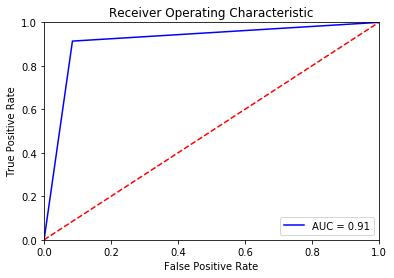

In [49]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
%matplotlib inline
fpr, tpr, thresholds = roc_curve(y_test, y_pred, pos_label=1)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


# Pytest

In [123]:
def test_read():
    read_file("2010 Federal STEM Education Inventory Data Set.xls")

### checking of assertion error for reading of file

In [139]:
test_read()

AssertionError: provided file is not in  .csv  format

## checking of column present in data or not

In [140]:
 def test_presence_col(data):
        col=col_to_drop(data)
        return col

In [141]:
data=pd.read_csv("ml_stem_analysis.csv")

In [142]:
data.drop('Growth',inplace=True,axis=1)

In [143]:
col=test_presence_col(data)

AssertionError: columns to drop is not contained in data: ['Growth']

# checking that unimportant feature to be removed from data is present or absent

In [137]:
col=col_to_drop(pd.read_csv("ml_stem_analysis.csv"))

In [138]:
data=dropping(pd.read_csv('stem_useful_feature.csv'),col)

AssertionError: columns to drop is not contained in data: ['Index Number', 'Investment Name', 'A) Brief Description', 'F2) Secondary Investment Objectives', 'F2) Secondary Investment Objectives 1', 'F2) Secondary Investment Objectives 2', 'F2) Secondary Investment Objectives 3', 'F2) Secondary Investment Objectives 4', 'F2) Secondary Investment Objectives 5', 'F2) Secondary Investment Objectives 6', 'F2) Secondary Investment Objectives 7', 'F2) Secondary Investment Objectives 8', 'G1) Primary Research Approaches', 'G1) Primary Research Approaches 1', 'G1) Primary Research Approaches 2', 'G1) Primary Research Approaches 3', 'G1) Primary Research Approaches 4', 'G2) Secondary Research Approaches', 'G2) Secondary Research Approaches 1', 'G2) Secondary Research Approaches 2', 'G2) Secondary Research Approaches 3', 'G2) Secondary Research Approaches 4', 'G3) Research Approaches Not Used', 'G3) Research Approaches Not Used 1', 'G3) Research Approaches Not Used 2', 'G3) Research Approaches Not Used 3', 'G3) Research Approaches Not Used 4', 'H) Educational Services or Products Produced', 'H) Educational Services or Products Produced 1', 'H) Educational Services or Products Produced 2', 'H) Educational Services or Products Produced 3', 'H) Educational Services or Products Produced 4', 'H) Educational Services or Products Produced 5', 'H) Educational Services or Products Produced 7', 'H) Educational Services or Products Produced 9', 'H) Educational Services or Products Produced 10', 'H) Educational Services or Products Produced 11', 'H) Educational Services or Products Produced 12', 'H) Educational Services or Products Produced 17', 'I1) STEM Learners Targeted? Specify. 1', 'I1) STEM Learners Targeted? Specify. 2', 'I2) Pre-service-service STEM Teachers Targeted? Specify. 1', 'I2) Pre-service-service STEM Teachers Targeted? Specify. 2', 'I2) Pre-service-service STEM Teachers Targeted? Specify. 3', 'I2) Pre-service-service STEM Teachers Targeted? Specify. 4', 'I3) In-service STEM Teachers Targeted? Specify.', 'I3) In-service STEM Teachers Targeted? Specify. 1', 'I3) In-service STEM Teachers Targeted? Specify. 2', 'I3) In-service STEM Teachers Targeted? Specify. 3', 'I3) In-service STEM Teachers Targeted? Specify. 4', 'I5) Education Researchers Targeted? ', 'I6) K-12 Staff/Administrators Targeted? Specify. 1', 'I6) K-12 Staff/Administrators Targeted? Specify. 2', 'I6) K-12 Staff/Administrators Targeted? Specify. 3', 'I6) K-12 Staff/Administrators Targeted? Specify. 4', 'I7) Post-secondary Instructors Targeted? Specify.', 'I7) Post-secondary Instructors Targeted? Specify. 1', 'I7) Post-secondary Instructors Targeted? Specify. 2', 'I7) Post-secondary Instructors Targeted? Specify. 3', 'I8) Post-secondary Staff Targeted? Specify.', 'I8) Post-secondary Staff Targeted? Specify. 3', 'I11) Other Target Group?', 'J) Focus on Underrepresented Groups in STEM 2', 'J) Focus on Underrepresented Groups in STEM 3', 'J) Focus on Underrepresented Groups in STEM 4', 'J) Focus on Underrepresented Groups in STEM 5', 'J) Focus on Underrepresented Groups in STEM 6', 'J) Focus on Underrepresented Groups in STEM 7', 'J) Focus on Underrepresented Groups in STEM 8', 'J) Focus on Underrepresented Groups in STEM 9', 'J) Focus on Underrepresented Groups in STEM 10', 'J) Focus on Underrepresented Groups in STEM 11', 'J) Focus on Underrepresented Groups in STEM 12', 'J) Focus on Underrepresented Groups in STEM 13', 'K) Eligibility Restrictions 1', 'K) Eligibility Restrictions 2', 'K) Eligibility Restrictions 3', 'L) Minority Serving Institutions 1', 'L) Minority Serving Institutions 2', 'L) Minority Serving Institutions 3', 'L) Minority Serving Institutions 4', 'L) Minority Serving Institutions 5', 'L) Minority Serving Institutions 6', 'M) Geographic Region 2', 'M) Geographic Region 3', 'M) Geographic Region 4', 'M) Geographic Region 6', 'M) Geographic Region 8', 'N) STEM Discipline Focus', 'N) STEM Discipline Focus 1', 'N) STEM Discipline Focus 2', 'N) STEM Discipline Focus 3', 'N) STEM Discipline Focus 4', 'N) STEM Discipline Focus 5', 'N) STEM Discipline Focus 6', 'N) STEM Discipline Focus 8', 'N) STEM Discipline Focus 9', 'N) STEM Discipline Focus 10', 'N) STEM Discipline Focus 11', 'O) Organization or Individual Funded', 'O) Organization or Individual Funded 1', 'O) Organization or Individual Funded 2', 'O) Organization or Individual Funded 3', 'O) Organization or Individual Funded 4', 'O) Organization or Individual Funded 5', 'O) Organization or Individual Funded 6', 'O) Organization or Individual Funded 7', 'O) Organization or Individual Funded 8', 'O) Organization or Individual Funded 9', 'O) Organization or Individual Funded 10', 'P) External Funding Allocation 1', 'P) External Funding Allocation 2', 'P) External Funding Allocation 3', 'R1) Joint Funding of Investment (with Agencies) 6', 'R1) Joint Funding of Investment (with Agencies) 8', 'R1) Joint Funding of Investment (with Agencies) 9', 'R1) Joint Funding of Investment (with Agencies) 11', 'R1) Joint Funding of Investment (with Agencies) 12', 'R2) Joint Funding of Investment (with Other) 2', 'R2) Joint Funding of Investment (with Other) 5', 'R2) Joint Funding of Investment (with Other) 7', 'R2) Joint Funding of Investment (with Other) 8', 'R2) Joint Funding of Investment (with Other) 10', 'R2) Joint Funding of Investment (with Other) 11', 'T) Partnerships with What Organization Types?', 'T) Partnerships with What Organization Types? 1', 'T) Partnerships with What Organization Types? 2', 'T) Partnerships with What Organization Types? 3', 'T) Partnerships with What Organization Types? 4', 'T) Partnerships with What Organization Types? 5', 'T) Partnerships with What Organization Types? 6', 'T) Partnerships with What Organization Types? 7', 'T) Partnerships with What Organization Types? 8', 'T) Partnerships with What Organization Types? 9', 'T) Partnerships with What Organization Types? 10', 'T) Partnerships with What Organization Types? 11', 'T) Partnerships with What Organization Types? 12', 'T) Partnerships with What Organization Types? 13', 'T) Partnerships with What Organization Types? 14', 'T) Partnerships with What Organization Types? 15', 'T) Partnerships with What Organization Types? 16', 'T) Partnerships with What Organization Types? 17', 'T) Partnerships with What Organization Types? 18', 'T) Partnerships with What Organization Types? 19', 'T) Partnerships with What Organization Types? 20', 'T) Partnerships with What Organization Types? 21', 'U) Measured Outputs 1', 'U) Measured Outputs 2', 'U) Measured Outputs 6', 'U) Measured Outputs 7', 'U) Measured Outputs 8', 'U) Measured Outputs 10', 'U) Measured Outputs 11', 'U) Measured Outputs 13', 'V) Outcomes Measured 1', 'V) Outcomes Measured 2', 'V) Outcomes Measured 3', 'V) Outcomes Measured 4', 'V) Outcomes Measured 6', 'V) Outcomes Measured 7', 'V) Outcomes Measured 8', 'V) Outcomes Measured 9', 'V) Outcomes Measured 10', 'V) Outcomes Measured 11', 'Y1) Formative Evaluation Type', 'Y1) Formative Evaluation Type 1', 'Y2) Summative Evaluation Type', 'Y2) Summative Evaluation Type 1', 'Y2) Summative Evaluation Type 2', 'Y3) Process or Implementation Evaluation Type', 'Y3) Process or Implementation Evaluation Type 1', 'Y3) Process or Implementation Evaluation Type 2', 'Y4) Portfolio Evaluation/Review Type', 'Y4) Portfolio Evaluation/Review Type 1', 'Y4) Portfolio Evaluation/Review Type 2', 'Y5) Expert Review Type', 'Y5) Expert Review Type 1', 'F2) Secondary Investment Objectives 2', 'F2) Secondary Investment Objectives 3', 'F2) Secondary Investment Objectives 4', 'F2) Secondary Investment Objectives 5', 'F2) Secondary Investment Objectives 6', 'F2) Secondary Investment Objectives 7', 'F2) Secondary Investment Objectives 8', 'F2) Secondary Investment Objectives 9', 'G1) Primary Research Approaches', 'G1) Primary Research Approaches 1', 'G1) Primary Research Approaches 2', 'G1) Primary Research Approaches 3', 'G1) Primary Research Approaches 4', 'G2) Secondary Research Approaches', 'G2) Secondary Research Approaches 1', 'G2) Secondary Research Approaches 2', 'G2) Secondary Research Approaches 3', 'G2) Secondary Research Approaches 4', 'G3) Research Approaches Not Used', 'G3) Research Approaches Not Used 1', 'G3) Research Approaches Not Used 2', 'G3) Research Approaches Not Used 3', 'G3) Research Approaches Not Used 4', 'H) Educational Services or Products Produced 3', 'H) Educational Services or Products Produced 5', 'H) Educational Services or Products Produced 6', 'H) Educational Services or Products Produced 8', 'H) Educational Services or Products Produced 11', 'H) Educational Services or Products Produced 12', 'H) Educational Services or Products Produced 13', 'H) Educational Services or Products Produced 14', 'H) Educational Services or Products Produced 15', 'H) Educational Services or Products Produced 16', 'H) Educational Services or Products Produced 17', 'H) Educational Services or Products Produced 18', 'I1) STEM Learners Targeted? Specify. 1', 'I1) STEM Learners Targeted? Specify. 2', 'I1) STEM Learners Targeted? Specify. 3', 'I1) STEM Learners Targeted? Specify. 4', 'I1) STEM Learners Targeted? Specify. 7', 'I2) Pre-service-service STEM Teachers Targeted? Specify.', 'I2) Pre-service-service STEM Teachers Targeted? Specify. 1', 'I2) Pre-service-service STEM Teachers Targeted? Specify. 2', 'I2) Pre-service-service STEM Teachers Targeted? Specify. 3', 'I2) Pre-service-service STEM Teachers Targeted? Specify. 4', 'I3) In-service STEM Teachers Targeted? Specify.', 'I3) In-service STEM Teachers Targeted? Specify. 1', 'I3) In-service STEM Teachers Targeted? Specify. 2', 'I3) In-service STEM Teachers Targeted? Specify. 3', 'I3) In-service STEM Teachers Targeted? Specify. 4', 'I4) Adult Learners Targeted?', 'I5) Education Researchers Targeted? ', 'I6) K-12 Staff/Administrators Targeted? Specify.', 'I6) K-12 Staff/Administrators Targeted? Specify. 1', 'I6) K-12 Staff/Administrators Targeted? Specify. 2', 'I6) K-12 Staff/Administrators Targeted? Specify. 3', 'I6) K-12 Staff/Administrators Targeted? Specify. 4', 'I7) Post-secondary Instructors Targeted? Specify.', 'I7) Post-secondary Instructors Targeted? Specify. 1', 'I7) Post-secondary Instructors Targeted? Specify. 2', 'I7) Post-secondary Instructors Targeted? Specify. 3', 'I8) Post-secondary Staff Targeted? Specify.', 'I8) Post-secondary Staff Targeted? Specify. 1', 'I8) Post-secondary Staff Targeted? Specify. 2', 'I8) Post-secondary Staff Targeted? Specify. 3', 'I9) Informal Stem Educators Targeted?', 'I10) Other Informal STEM Education Staff Targeted?', 'I11) Other Target Group?', 'I11) Other Target Group? 1', 'J) Focus on Underrepresented Groups in STEM 1', 'J) Focus on Underrepresented Groups in STEM 2', 'J) Focus on Underrepresented Groups in STEM 3', 'J) Focus on Underrepresented Groups in STEM 4', 'J) Focus on Underrepresented Groups in STEM 5', 'J) Focus on Underrepresented Groups in STEM 6', 'J) Focus on Underrepresented Groups in STEM 7', 'J) Focus on Underrepresented Groups in STEM 8', 'J) Focus on Underrepresented Groups in STEM 9', 'J) Focus on Underrepresented Groups in STEM 10', 'J) Focus on Underrepresented Groups in STEM 11', 'J) Focus on Underrepresented Groups in STEM 12', 'J) Focus on Underrepresented Groups in STEM 13', 'J) Focus on Underrepresented Groups in STEM 14', 'K) Eligibility Restrictions 2', 'K) Eligibility Restrictions 3', 'L) Minority Serving Institutions 1', 'L) Minority Serving Institutions 2', 'L) Minority Serving Institutions 3', 'L) Minority Serving Institutions 4', 'L) Minority Serving Institutions 5', 'L) Minority Serving Institutions 6', 'M) Geographic Region 2', 'M) Geographic Region 3', 'M) Geographic Region 4', 'M) Geographic Region 5', 'M) Geographic Region 6', 'M) Geographic Region 7', 'M) Geographic Region 8', 'M) Geographic Region 9', 'N) STEM Discipline Focus', 'N) STEM Discipline Focus 1', 'N) STEM Discipline Focus 2', 'N) STEM Discipline Focus 3', 'N) STEM Discipline Focus 4', 'N) STEM Discipline Focus 5', 'N) STEM Discipline Focus 6', 'N) STEM Discipline Focus 7', 'N) STEM Discipline Focus 8', 'N) STEM Discipline Focus 9', 'N) STEM Discipline Focus 10', 'O) Organization or Individual Funded', 'O) Organization or Individual Funded 1', 'O) Organization or Individual Funded 2', 'O) Organization or Individual Funded 3', 'O) Organization or Individual Funded 4', 'O) Organization or Individual Funded 5', 'O) Organization or Individual Funded 6', 'O) Organization or Individual Funded 7', 'O) Organization or Individual Funded 8', 'O) Organization or Individual Funded 9', 'O) Organization or Individual Funded 10', 'O) Organization or Individual Funded 11', 'P) External Funding Allocation', 'P) External Funding Allocation 1', 'P) External Funding Allocation 2', 'P) External Funding Allocation 3', 'P) External Funding Allocation 4', 'P) External Funding Allocation 5', 'R1) Joint Funding of Investment (with Agencies)', 'R1) Joint Funding of Investment (with Agencies) 1', 'R1) Joint Funding of Investment (with Agencies) 2', 'R1) Joint Funding of Investment (with Agencies) 3', 'R1) Joint Funding of Investment (with Agencies) 4', 'R1) Joint Funding of Investment (with Agencies) 5', 'R1) Joint Funding of Investment (with Agencies) 6', 'R1) Joint Funding of Investment (with Agencies) 7', 'R1) Joint Funding of Investment (with Agencies) 8', 'R1) Joint Funding of Investment (with Agencies) 9', 'R1) Joint Funding of Investment (with Agencies) 10', 'R1) Joint Funding of Investment (with Agencies) 11', 'R1) Joint Funding of Investment (with Agencies) 12', 'R2) Joint Funding of Investment (with Other)', 'R2) Joint Funding of Investment (with Other) 1', 'R2) Joint Funding of Investment (with Other) 2', 'R2) Joint Funding of Investment (with Other) 3', 'R2) Joint Funding of Investment (with Other) 4', 'R2) Joint Funding of Investment (with Other) 5', 'R2) Joint Funding of Investment (with Other) 6', 'R2) Joint Funding of Investment (with Other) 7', 'R2) Joint Funding of Investment (with Other) 8', 'R2) Joint Funding of Investment (with Other) 9', 'R2) Joint Funding of Investment (with Other) 10', 'R2) Joint Funding of Investment (with Other) 11', 'T) Partnerships with What Organization Types?', 'T) Partnerships with What Organization Types? 1', 'T) Partnerships with What Organization Types? 2', 'T) Partnerships with What Organization Types? 3', 'T) Partnerships with What Organization Types? 4', 'T) Partnerships with What Organization Types? 5', 'T) Partnerships with What Organization Types? 6', 'T) Partnerships with What Organization Types? 7', 'T) Partnerships with What Organization Types? 8', 'T) Partnerships with What Organization Types? 9', 'T) Partnerships with What Organization Types? 10', 'T) Partnerships with What Organization Types? 11', 'T) Partnerships with What Organization Types? 12', 'T) Partnerships with What Organization Types? 13', 'T) Partnerships with What Organization Types? 14', 'T) Partnerships with What Organization Types? 15', 'T) Partnerships with What Organization Types? 16', 'T) Partnerships with What Organization Types? 17', 'T) Partnerships with What Organization Types? 18', 'T) Partnerships with What Organization Types? 19', 'T) Partnerships with What Organization Types? 20', 'T) Partnerships with What Organization Types? 21', 'T) Partnerships with What Organization Types? 22', 'U) Measured Outputs 2', 'U) Measured Outputs 3', 'U) Measured Outputs 4', 'U) Measured Outputs 5', 'U) Measured Outputs 6', 'U) Measured Outputs 7', 'U) Measured Outputs 8', 'U) Measured Outputs 9', 'U) Measured Outputs 10', 'U) Measured Outputs 11', 'U) Measured Outputs 12', 'U) Measured Outputs 13', 'U) Measured Outputs 14', 'V) Outcomes Measured 1', 'V) Outcomes Measured 2', 'V) Outcomes Measured 3', 'V) Outcomes Measured 4', 'V) Outcomes Measured 5', 'V) Outcomes Measured 6', 'V) Outcomes Measured 7', 'V) Outcomes Measured 8', 'V) Outcomes Measured 9', 'V) Outcomes Measured 10', 'V) Outcomes Measured 11', 'V) Outcomes Measured 12', 'W) Measurement Instruments Used', 'W) Measurement Instruments Used 1', 'W) Measurement Instruments Used 2', 'Y1) Formative Evaluation Type', 'Y1) Formative Evaluation Type 1', 'Y1) Formative Evaluation Type 2', 'Y2) Summative Evaluation Type', 'Y2) Summative Evaluation Type 1', 'Y2) Summative Evaluation Type 2', 'Y3) Process or Implementation Evaluation Type', 'Y3) Process or Implementation Evaluation Type 1', 'Y3) Process or Implementation Evaluation Type 2', 'Y4) Portfolio Evaluation/Review Type', 'Y4) Portfolio Evaluation/Review Type 1', 'Y4) Portfolio Evaluation/Review Type 2', 'Y5) Expert Review Type', 'Y5) Expert Review Type 1']